In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class BasicConv(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, stride, bias=True, norm=False, relu=True, transpose=False):
        super(BasicConv, self).__init__()
        if bias and norm:
            bias = False

        padding = kernel_size // 2
        layers = list()
        if transpose:
            padding = kernel_size // 2 -1
            layers.append(nn.ConvTranspose2d(in_channel, out_channel, kernel_size, padding=padding, stride=stride, bias=bias))
        else:
            layers.append(
                nn.Conv2d(in_channel, out_channel, kernel_size, padding=padding, stride=stride, bias=bias))
        if norm:
            layers.append(nn.BatchNorm2d(out_channel))
        if relu:
            layers.append(nn.GELU())
        self.main = nn.Sequential(*layers)

    def forward(self, x):
        return self.main(x)

In [ ]:
class spatial_strip_att(nn.Module):
    def __init__(self, dim, kernel=3, dilation=1, group=2, H=True) -> None:
        super().__init__()

        self.k = kernel
        pad = dilation*(kernel-1) // 2
        self.kernel = (1, kernel) if H else (kernel, 1)
        self.padding = (kernel//2, 1) if H else (1, kernel//2)
        self.dilation = dilation
        self.group = group
        self.pad = nn.ReflectionPad2d((pad, pad, 0, 0)) if H else nn.ReflectionPad2d((0, 0, pad, pad))
        self.conv = nn.Conv2d(dim, group*kernel, kernel_size=1, stride=1, bias=False)
        self.ap = nn.AdaptiveAvgPool2d((1, 1))
        self.filter_act = nn.Tanh()
        self.inside_all = nn.Parameter(torch.zeros(dim,1,1), requires_grad=True)
        self.lamb_l = nn.Parameter(torch.zeros(dim), requires_grad=True)
        self.lamb_h = nn.Parameter(torch.zeros(dim), requires_grad=True)
        gap_kernel = (None,1) if H else (1, None)
        self.gap = nn.AdaptiveAvgPool2d(gap_kernel)

    def forward(self, x):
        identity_input = x.clone()
        filter = self.ap(x)
        filter = self.conv(filter)
        n, c, h, w = x.shape
        x = F.unfold(self.pad(x), kernel_size=self.kernel, dilation=self.dilation).reshape(n, self.group, c//self.group, self.k, h*w)
        n, c1, p, q = filter.shape
        filter = filter.reshape(n, c1//self.k, self.k, p*q).unsqueeze(2)
        filter = self.filter_act(filter)
        out = torch.sum(x * filter, dim=3).reshape(n, c, h, w)

        out_low = out * (self.inside_all + 1.) - self.inside_all * self.gap(identity_input)
        out_low = out_low * self.lamb_l[None,:,None,None]
        out_high = identity_input * (self.lamb_h[None,:,None,None]+1.)

        return out_low + out_high

In [ ]:
class dynamic_filter(nn.Module):
    def __init__(self, inchannels, kernel_size=3, dilation=1, stride=1, group=8):
        super(dynamic_filter, self).__init__()
        self.stride = stride
        self.kernel_size = kernel_size
        self.group = group
        self.dilation = dilation

        self.conv = nn.Conv2d(inchannels, group*kernel_size**2, kernel_size=1, stride=1, bias=False)
        self.bn = nn.BatchNorm2d(group*kernel_size**2)
        self.act = nn.Tanh()

        nn.init.kaiming_normal_(self.conv.weight, mode='fan_out', nonlinearity='relu')
        self.lamb_l = nn.Parameter(torch.zeros(inchannels), requires_grad=True)
        self.lamb_h = nn.Parameter(torch.zeros(inchannels), requires_grad=True)
        self.pad = nn.ReflectionPad2d(self.dilation*(kernel_size-1)//2)

        self.ap = nn.AdaptiveAvgPool2d((1, 1))
        self.gap = nn.AdaptiveAvgPool2d(1)

        self.inside_all = nn.Parameter(torch.zeros(inchannels,1,1), requires_grad=True)

    def forward(self, x):
        identity_input = x
        low_filter = self.ap(x)
        low_filter = self.conv(low_filter)
        low_filter = self.bn(low_filter)

        n, c, h, w = x.shape
        x = F.unfold(self.pad(x), kernel_size=self.kernel_size, dilation=self.dilation).reshape(n, self.group, c//self.group, self.kernel_size**2, h*w)

        n,c1,p,q = low_filter.shape
        low_filter = low_filter.reshape(n, c1//self.kernel_size**2, self.kernel_size**2, p*q).unsqueeze(2)

        low_filter = self.act(low_filter)

        low_part = torch.sum(x * low_filter, dim=3).reshape(n, c, h, w)

        out_low = low_part * (self.inside_all + 1.) - self.inside_all * self.gap(identity_input)

        out_low = out_low * self.lamb_l[None,:,None,None]

        out_high = (identity_input) * (self.lamb_h[None,:,None,None] + 1.)

        return out_low + out_high

In [ ]:
class cubic_attention(nn.Module):
    def __init__(self, dim, group, dilation, kernel) -> None:
        super().__init__()

        self.H_spatial_att = spatial_strip_att(dim, dilation=dilation, group=group, kernel=kernel)
        self.W_spatial_att = spatial_strip_att(dim, dilation=dilation, group=group, kernel=kernel, H=False)
        self.gamma = nn.Parameter(torch.zeros(dim,1,1))
        self.beta = nn.Parameter(torch.ones(dim,1,1))

    def forward(self, x):
        out = self.H_spatial_att(x)
        out = self.W_spatial_att(out)
        return self.gamma * out + x * self.beta

In [ ]:
class MultiShapeKernel(nn.Module):
    def __init__(self, dim, kernel_size=3, dilation=1, group=8):
        super().__init__()

        self.square_att = dynamic_filter(inchannels=dim, dilation=dilation, group=group, kernel_size=kernel_size)
        self.strip_att = cubic_attention(dim, group=group, dilation=dilation, kernel=kernel_size)

    def forward(self, x):

        x1 = self.strip_att(x)
        x2 = self.square_att(x)

        return x1+x2

In [ ]:
class BasicConv(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, stride, bias=True, norm=False, relu=True, transpose=False):
        super(BasicConv, self).__init__()
        if bias and norm:
            bias = False

        padding = kernel_size // 2
        layers = list()
        if transpose:
            padding = kernel_size // 2 -1
            layers.append(nn.ConvTranspose2d(in_channel, out_channel, kernel_size, padding=padding, stride=stride, bias=bias))
        else:
            layers.append(
                nn.Conv2d(in_channel, out_channel, kernel_size, padding=padding, stride=stride, bias=bias))
        if norm:
            layers.append(nn.BatchNorm2d(out_channel))
        if relu:
            layers.append(nn.GELU())
        self.main = nn.Sequential(*layers)

    def forward(self, x):
        return self.main(x)

In [ ]:
class DeepPoolLayer(nn.Module):
    def __init__(self, k, k_out):
        super(DeepPoolLayer, self).__init__()
        self.pools_sizes = [8,4,2]
        dilation = [3,7,9]
        pools, convs, dynas = [],[],[]
        for j, i in enumerate(self.pools_sizes):
            pools.append(nn.AvgPool2d(kernel_size=i, stride=i))
            convs.append(nn.Conv2d(k, k, 3, 1, 1, bias=False))
            dynas.append(MultiShapeKernel(dim=k, kernel_size=3, dilation=dilation[j]))
        self.pools = nn.ModuleList(pools)
        self.convs = nn.ModuleList(convs)
        self.dynas = nn.ModuleList(dynas)
        self.relu = nn.GELU()
        self.conv_sum = nn.Conv2d(k, k_out, 3, 1, 1, bias=False)

    def forward(self, x):
        x_size = x.size()
        resl = x
        for i in range(len(self.pools_sizes)):
            if i == 0:
                y = self.dynas[i](self.convs[i](self.pools[i](x)))
            else:
                y = self.dynas[i](self.convs[i](self.pools[i](x)+y_up))
            resl = torch.add(resl, F.interpolate(y, x_size[2:], mode='bilinear', align_corners=True))
            if i != len(self.pools_sizes)-1:
                y_up = F.interpolate(y, scale_factor=2, mode='bilinear', align_corners=True)
        resl = self.relu(resl)
        resl = self.conv_sum(resl)

        return resl

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_channel, out_channel, filter=False):
        super(ResBlock, self).__init__()
        self.main = nn.Sequential(
            BasicConv(in_channel, out_channel, kernel_size=3, stride=1, relu=True),
            DeepPoolLayer(in_channel, out_channel) if filter else nn.Identity(),
            BasicConv(out_channel, out_channel, kernel_size=3, stride=1, relu=False)
        )

    def forward(self, x):
        return self.main(x) + x

In [ ]:
class EBlock(nn.Module):
    def __init__(self, out_channel, num_res=8):
        super(EBlock, self).__init__()

        layers = [ResBlock(out_channel, out_channel) for _ in range(num_res-1)]
        layers.append(ResBlock(out_channel, out_channel, filter=True))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [ ]:
class DBlock(nn.Module):
    def __init__(self, channel, num_res=8):
        super(DBlock, self).__init__()

        layers = [ResBlock(channel, channel) for _ in range(num_res-1)]
        layers.append(ResBlock(channel, channel, filter=True))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [ ]:
class SCM(nn.Module):
    def __init__(self, out_plane):
        super(SCM, self).__init__()
        self.main = nn.Sequential(
            BasicConv(3, out_plane//4, kernel_size=3, stride=1, relu=True),
            BasicConv(out_plane // 4, out_plane // 2, kernel_size=1, stride=1, relu=True),
            BasicConv(out_plane // 2, out_plane // 2, kernel_size=3, stride=1, relu=True),
            BasicConv(out_plane // 2, out_plane, kernel_size=1, stride=1, relu=False),
            nn.InstanceNorm2d(out_plane, affine=True)
        )

    def forward(self, x):
        x = self.main(x)
        return x

In [ ]:
class FAM(nn.Module):
    def __init__(self, channel):
        super(FAM, self).__init__()
        self.merge = BasicConv(channel*2, channel, kernel_size=3, stride=1, relu=False)

    def forward(self, x1, x2):
        return self.merge(torch.cat([x1, x2], dim=1))

In [ ]:
class ConvIR(nn.Module):
    def __init__(self, num_res=16):
        super(ConvIR, self).__init__()

        base_channel = 32

        self.Encoder = nn.ModuleList([
            EBlock(base_channel, num_res),
            EBlock(base_channel*2, num_res),
            EBlock(base_channel*4, num_res),
        ])

        self.feat_extract = nn.ModuleList([
            BasicConv(3, base_channel, kernel_size=3, relu=True, stride=1),
            BasicConv(base_channel, base_channel*2, kernel_size=3, relu=True, stride=2),
            BasicConv(base_channel*2, base_channel*4, kernel_size=3, relu=True, stride=2),
            BasicConv(base_channel*4, base_channel*2, kernel_size=4, relu=True, stride=2, transpose=True),
            BasicConv(base_channel*2, base_channel, kernel_size=4, relu=True, stride=2, transpose=True),
            BasicConv(base_channel, 3, kernel_size=3, relu=False, stride=1)
        ])

        self.Decoder = nn.ModuleList([
            DBlock(base_channel * 4, num_res),
            DBlock(base_channel * 2, num_res),
            DBlock(base_channel, num_res)
        ])

        self.Convs = nn.ModuleList([
            BasicConv(base_channel * 4, base_channel * 2, kernel_size=1, relu=True, stride=1),
            BasicConv(base_channel * 2, base_channel, kernel_size=1, relu=True, stride=1),
        ])

        self.ConvsOut = nn.ModuleList(
            [
                BasicConv(base_channel * 4, 3, kernel_size=3, relu=False, stride=1),
                BasicConv(base_channel * 2, 3, kernel_size=3, relu=False, stride=1),
            ]
        )

        self.FAM1 = FAM(base_channel * 4)
        self.SCM1 = SCM(base_channel * 4)
        self.FAM2 = FAM(base_channel * 2)
        self.SCM2 = SCM(base_channel * 2)

    def forward(self, x):
        x_2 = F.resize(x, 2)
        x_4 = F.resize(x_2, 2)
        z2 = self.SCM2(x_2)
        z4 = self.SCM1(x_4)

        outputs = list()
        # 256
        x_ = self.feat_extract[0](x)
        res1 = self.Encoder[0](x_)
        # 128
        z = self.feat_extract[1](res1)
        z = self.FAM2(z, z2)
        res2 = self.Encoder[1](z)
        # 64
        z = self.feat_extract[2](res2)
        z = self.FAM1(z, z4)
        z = self.Encoder[2](z)

        z = self.Decoder[0](z)
        z_ = self.ConvsOut[0](z)
        # 128
        z = self.feat_extract[3](z)
        outputs.append(z_+x_4)

        z = torch.cat([z, res2], dim=1)
        z = self.Convs[0](z)
        z = self.Decoder[1](z)
        z_ = self.ConvsOut[1](z)
        # 256
        z = self.feat_extract[4](z)
        outputs.append(z_+x_2)

        z = torch.cat([z, res1], dim=1)
        z = self.Convs[1](z)
        z = self.Decoder[2](z)
        z = self.feat_extract[5](z)
        outputs.append(z+x)

        return outputs

In [ ]:
def build_net():
    return ConvIR()

In [ ]:
import time
import numpy as np

In [ ]:
class Adder(object):
    def __init__(self):
        self.count = 0
        self.num = float(0)

    def reset(self):
        self.count = 0
        self.num = float(0)

    def __call__(self, num):
        self.count += 1
        self.num += num

    def average(self):
        return self.num / self.count

In [ ]:
class Timer(object):
    def __init__(self, option='s'):
        self.tm = 0
        self.option = option
        if option == 's':
            self.devider = 1
        elif option == 'm':
            self.devider = 60
        else:
            self.devider = 3600

    def tic(self):
        self.tm = time.time()

    def toc(self):
        return (time.time() - self.tm) / self.devider

In [ ]:
def check_lr(optimizer):
    for i, param_group in enumerate(optimizer.param_groups):
        lr = param_group['lr']
    return lr

In [ ]:
import random
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

In [ ]:
class PairRandomCrop(transforms.RandomCrop):

    def __call__(self, image, label):

        w,h = image.size[0], image.size[1]
        padw = self.size[0]-w if w<self.size[0] else 0
        padh = self.size[0]-h if h<self.size[0] else 0
        if padw!=0 or padh!=0:
            image = F.pad(image, (0,0,padw,padh), padding_mode='reflect')
            label = F.pad(label, (0,0,padw,padh), padding_mode='reflect')

        i, j, h, w = self.get_params(image, self.size)

        return F.crop(image, i, j, h, w), F.crop(label, i, j, h, w)

In [ ]:
class PairCenterCrop(transforms.CenterCrop):
    def __call__(self, image, lable):

        image = F.center_crop(image, (self.size[0], self.size[0]))
        lable = F.center_crop(lable, (self.size[0], self.size[0]))

        return image, lable

In [ ]:
class PairCompose(transforms.Compose):
    def __call__(self, image, label):
        for t in self.transforms:
            image, label = t(image, label)
        return image, label

In [ ]:
class PairRandomHorizontalFilp(transforms.RandomHorizontalFlip):
    def __call__(self, img, label):
        """
        Args:
            img (PIL Image): Image to be flipped.

        Returns:
            PIL Image: Randomly flipped image.
        """
        if random.random() < self.p:
            return F.hflip(img), F.hflip(label)
        return img, label

In [ ]:
class PairToTensor(transforms.ToTensor):
    def __call__(self, pic, label):
        """
        Args:
            pic (PIL Image or numpy.ndarray): Image to be converted to tensor.

        Returns:
            Tensor: Converted image.
        """
        return F.to_tensor(pic), F.to_tensor(label)

In [ ]:
!wget http://ivc.uwaterloo.ca/database/WaterlooExploration/exploration_database_and_code.rar

--2024-10-18 05:29:11--  http://ivc.uwaterloo.ca/database/WaterlooExploration/exploration_database_and_code.rar
Resolving ivc.uwaterloo.ca (ivc.uwaterloo.ca)... 129.97.92.151
Connecting to ivc.uwaterloo.ca (ivc.uwaterloo.ca)|129.97.92.151|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ivc.uwaterloo.ca/database/WaterlooExploration/exploration_database_and_code.rar [following]
--2024-10-18 05:29:12--  https://ivc.uwaterloo.ca/database/WaterlooExploration/exploration_database_and_code.rar
Connecting to ivc.uwaterloo.ca (ivc.uwaterloo.ca)|129.97.92.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2076625910 (1.9G) [application/vnd.rar]
Saving to: ‘exploration_database_and_code.rar’

exploration_databas 100%[===================>]   1.93G  44.7MB/s    in 46s     

2024-10-18 05:29:58 (42.8 MB/s) - ‘exploration_database_and_code.rar’ saved [2076625910/2076625910]



In [ ]:
!unrar x exploration_database_and_code.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from exploration_database_and_code.rar

Creating    exploration_database_and_code                             OK
Creating    exploration_database_and_code/data                        OK
Creating    exploration_database_and_code/data/pairs                  OK
Extracting  exploration_database_and_code/data/pairs/pairs1.mat            0%  1%  OK 
Extracting  exploration_database_and_code/data/pairs/pairs10.mat           1%  2%  OK 
Extracting  exploration_database_and_code/data/pairs/pairs11.mat           2%  3%  OK 
Extracting  exploration_database_and_code/data/pairs/pairs12.mat           3%  4%  OK 
Extracting  exploration_database_and_code/data/pairs/pairs13.mat           4%  5%  OK 
Extracting  exploration_database_and_code/data/pairs/pairs14.mat           5%  6%  OK 
Extracting  exploration_database_and_code/data/pairs/p

In [ ]:
import os
from PIL import Image as Image
from torch.utils.data import Dataset, DataLoader

In [ ]:
class DenoiseDataset(Dataset):
    def __init__(self, image_dir, transform=None, is_test=False):
        self.image_dir = image_dir
        self.image_list = os.listdir(os.path.join(image_dir, 'input/'))
        self._check_image(self.image_list)
        self.image_list.sort()
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.image_dir, 'input', self.image_list[idx]))
        label = Image.open(os.path.join(self.image_dir,'', self.image_list[idx]))

        if self.transform:
            image, label = self.transform(image, label)
        else:
            image = F.to_tensor(image)
            label = F.to_tensor(label)
        if self.is_test:
            name = self.image_list[idx]
            return image, label, name
        return image, label

    @staticmethod
    def _check_image(lst):
        for x in lst:
            splits = x.split('.')
            if splits[-1] not in ['png', 'jpg', 'jpeg', 'bmp']:
                raise ValueError

In [ ]:
import os
import numpy as np
from PIL import Image

def add_gaussian_noise(image, mean=0, std=25):
    # Convert the image to a numpy array
    image_array = np.array(image)
    # Generate Gaussian noise
    noise = np.random.normal(mean, std, image_array.shape).astype(np.uint8)
    # Add noise to the image
    noisy_image = np.clip(image_array + noise, 0, 255)  # Ensure pixel values remain valid
    return Image.fromarray(noisy_image)

# Set your directories
input_folder = '/content/exploration_database_and_code/pristine_images'  # Replace with the path to your folder of images
output_folder = '/content/exploration_database_and_code/pristine_images/input'    # Replace with the path where you want to save noisy images

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Loop through all images in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp')):  # Add other image formats if needed
        # Load the image
        image_path = os.path.join(input_folder, filename)
        image = Image.open(image_path)

        # Add Gaussian noise
        noisy_image = add_gaussian_noise(image)

        # Save the noisy image
        noisy_image.save(os.path.join(output_folder, filename))

print("Noisy images saved in:", output_folder)


Noisy images saved in: /content/exploration_database_and_code/pristine_images/input


In [ ]:
def train_dataloader(path, batch_size=64, num_workers=0, use_transform=True):
    image_dir = path

    transform = None
    if use_transform:
        transform = PairCompose(
            [
                PairRandomCrop(256),
                PairRandomHorizontalFilp(),
                PairToTensor()
            ]
        )
    dataloader = DataLoader(
        DenoiseDataset(image_dir, transform=transform),
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )
    return dataloader

In [ ]:
def test_dataloader(path, batch_size=1, num_workers=0):
    image_dir = os.path.join(path, 'valid')
    dataloader = DataLoader(
        DenoiseDataset(image_dir, is_test=True),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return dataloader

In [ ]:
def valid_dataloader(path, batch_size=1, num_workers=0):
    transform = PairCompose(
        [
            PairCenterCrop(128),
            PairToTensor()
        ]
    )
    dataloader = DataLoader(
        DenoiseDataset(path, transform=transform),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )

    return dataloader

In [ ]:
from skimage.metrics import peak_signal_noise_ratio

In [ ]:
def _valid(model, args, ep):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    gopro = valid_dataloader(args.valid_data, batch_size=1, num_workers=0)
    model.eval()
    psnr_adder = Adder()

    with torch.no_grad():
        print('Start Derain Evaluation')
        factor = 32
        for idx, data in enumerate(gopro):
            input_img, label_img = data
            input_img = input_img.to(device)

            h, w = input_img.shape[2], input_img.shape[3]
            H, W = ((h+factor)//factor)*factor, ((w+factor)//factor*factor)
            padh = H-h if h%factor!=0 else 0
            padw = W-w if w%factor!=0 else 0
            input_img = f.pad(input_img, (0, padw, 0, padh), 'reflect')

            if not os.path.exists(os.path.join(args.result_dir, '%d' % (ep))):
                os.mkdir(os.path.join(args.result_dir, '%d' % (ep)))

            pred = model(input_img)[2]
            pred = pred[:,:,:h,:w]

            pred_clip = torch.clamp(pred, 0, 1)
            p_numpy = pred_clip.squeeze(0).cpu().numpy()
            label_numpy = label_img.squeeze(0).cpu().numpy()

            psnr = peak_signal_noise_ratio(p_numpy, label_numpy, data_range=1)

            psnr_adder(psnr)
            print('\r%03d'%idx, end=' ')

    print('\n')
    model.train()
    return psnr_adder.average()

In [ ]:
def test_dataloader(path, batch_size=1, num_workers=0):
    dataloader = DataLoader(
        DenoiseDataset(path, is_test=True),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return dataloader

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
class GradualWarmupScheduler(_LRScheduler):

    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        self.multiplier = multiplier
        if self.multiplier < 1.:
            raise ValueError('multiplier should be greater thant or equal to 1.')
        self.total_epoch = total_epoch
        self.after_scheduler = after_scheduler
        self.finished = False
        super(GradualWarmupScheduler, self).__init__(optimizer)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]

        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

    def step_ReduceLROnPlateau(self, metrics, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch if epoch != 0 else 1  # ReduceLROnPlateau is called at the end of epoch, whereas others are called at beginning
        if self.last_epoch <= self.total_epoch:
            warmup_lr = [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]
            for param_group, lr in zip(self.optimizer.param_groups, warmup_lr):
                param_group['lr'] = lr
        else:
            if epoch is None:
                self.after_scheduler.step(metrics, None)
            else:
                self.after_scheduler.step(metrics, epoch - self.total_epoch)

    def step(self, epoch=None, metrics=None):
        if type(self.after_scheduler) != ReduceLROnPlateau:
            if self.finished and self.after_scheduler:
                if epoch is None:
                    self.after_scheduler.step(None)
                else:
                    self.after_scheduler.step(epoch - self.total_epoch)
            else:
                return super(GradualWarmupScheduler, self).step(epoch)
        else:
            self.step_ReduceLROnPlateau(metrics, epoch)

In [ ]:
def _train(model, args):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = torch.nn.L1Loss()

    optimizer = torch.optim.Adam(model.parameters(), lr=3e-5, betas=(0.9, 0.999), eps=1e-8)
    dataloader = train_dataloader("/content/exploration_database_and_code/pristine_images", 64, 8)
    max_iter = len(dataloader)
    warmup_epochs=3
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30-warmup_epochs, eta_min=1e-6)
    scheduler = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=warmup_epochs, after_scheduler=scheduler_cosine)
    scheduler.step()
    epoch = 1
    # if args.resume:
    #     state = torch.load(args.resume)
    #     epoch = state['epoch']
    #     optimizer.load_state_dict(state['optimizer'])
    #     model.load_state_dict(state['model'])
    #     print('Resume from %d'%epoch)
    #     epoch += 1



    writer = SummaryWriter()
    epoch_pixel_adder = Adder()
    epoch_fft_adder = Adder()
    iter_pixel_adder = Adder()
    iter_fft_adder = Adder()
    epoch_timer = Timer('m')
    iter_timer = Timer('m')
    best_psnr=-1

    for epoch_idx in range(epoch, 30 + 1):
        epoch_timer.tic()
        iter_timer.tic()
        for iter_idx, batch_data in enumerate(dataloader):

            input_img, label_img = batch_data
            input_img = input_img.to(device)
            label_img = label_img.to(device)

            optimizer.zero_grad()
            pred_img = model(input_img)
            print(pred_img)
            label_img2 = F.interpolate(label_img, scale_factor=0.5, mode='bilinear')
            label_img4 = F.interpolate(label_img, scale_factor=0.25, mode='bilinear')
            l1 = criterion(pred_img[0], label_img4)
            l2 = criterion(pred_img[1], label_img2)
            l3 = criterion(pred_img[2], label_img)
            loss_content = l1+l2+l3

            label_fft1 = torch.fft.fft2(label_img4, dim=(-2,-1))
            label_fft1 = torch.stack((label_fft1.real, label_fft1.imag), -1)

            pred_fft1 = torch.fft.fft2(pred_img[0], dim=(-2,-1))
            pred_fft1 = torch.stack((pred_fft1.real, pred_fft1.imag), -1)

            label_fft2 = torch.fft.fft2(label_img2, dim=(-2,-1))
            label_fft2 = torch.stack((label_fft2.real, label_fft2.imag), -1)

            pred_fft2 = torch.fft.fft2(pred_img[1], dim=(-2,-1))
            pred_fft2 = torch.stack((pred_fft2.real, pred_fft2.imag), -1)

            label_fft3 = torch.fft.fft2(label_img, dim=(-2,-1))
            label_fft3 = torch.stack((label_fft3.real, label_fft3.imag), -1)

            pred_fft3 = torch.fft.fft2(pred_img[2], dim=(-2,-1))
            pred_fft3 = torch.stack((pred_fft3.real, pred_fft3.imag), -1)

            f1 = criterion(pred_fft1, label_fft1)
            f2 = criterion(pred_fft2, label_fft2)
            f3 = criterion(pred_fft3, label_fft3)
            loss_fft = f1+f2+f3

            loss = loss_content + 0.1 * loss_fft
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.01)
            optimizer.step()

            iter_pixel_adder(loss_content.item())
            iter_fft_adder(loss_fft.item())

            epoch_pixel_adder(loss_content.item())
            epoch_fft_adder(loss_fft.item())

            if (iter_idx + 1) % args.print_freq == 0:
                print("Time: %7.4f Epoch: %03d Iter: %4d/%4d LR: %.10f Loss content: %7.4f Loss fft: %7.4f" % (
                    iter_timer.toc(), epoch_idx, iter_idx + 1, max_iter, scheduler.get_lr()[0], iter_pixel_adder.average(),
                    iter_fft_adder.average()))
                writer.add_scalar('Pixel Loss', iter_pixel_adder.average(), iter_idx + (epoch_idx-1)* max_iter)
                writer.add_scalar('FFT Loss', iter_fft_adder.average(), iter_idx + (epoch_idx - 1) * max_iter)

                iter_timer.tic()
                iter_pixel_adder.reset()
                iter_fft_adder.reset()
        overwrite_name = os.path.join(args.model_save_dir, 'model.pkl')
        torch.save({'model': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'epoch': epoch_idx}, overwrite_name)

        if epoch_idx % args.save_freq == 0:
            save_name = os.path.join(args.model_save_dir, 'model_%d.pkl' % epoch_idx)
            torch.save({'model': model.state_dict()}, save_name)
        print("EPOCH: %02d\nElapsed time: %4.2f Epoch Pixel Loss: %7.4f Epoch FFT Loss: %7.4f" % (
            epoch_idx, epoch_timer.toc(), epoch_pixel_adder.average(), epoch_fft_adder.average()))
        epoch_fft_adder.reset()
        epoch_pixel_adder.reset()
        scheduler.step()
        if epoch_idx % args.valid_freq == 0:
            val_rain = _valid(model, args, epoch_idx)
            print('%03d epoch \n Average DeRain PSNR %.2f dB' % (epoch_idx, val_rain))
            writer.add_scalar('PSNR_DeRain', val_rain, epoch_idx)
            if val_rain >= best_psnr:
                torch.save({'model': model.state_dict()}, os.path.join(args.model_save_dir, 'Best.pkl'))
    save_name = os.path.join(args.model_save_dir, 'Final.pkl')
    torch.save({'model': model.state_dict()}, save_name)

In [ ]:
from torch.backends import cudnn

In [ ]:
def main(args):
    cudnn.benchmark = True

    if not os.path.exists('results/'):
        os.makedirs(args.model_save_dir)
    if not os.path.exists('results/' + args.model_name + '/'):
        os.makedirs('results/' + args.model_name + '/')
    if not os.path.exists(args.result_dir):
        os.makedirs(args.result_dir)

    model = build_net()
    print(model)

    if torch.cuda.is_available():
        model.cuda()
    if args.mode == 'train':
        _train(model, args)

    # elif args.mode == 'test':
    #     _eval(model, args)

In [ ]:
model = build_net()
print(model)

ConvIR(
  (Encoder): ModuleList(
    (0): EBlock(
      (layers): Sequential(
        (0): ResBlock(
          (main): Sequential(
            (0): BasicConv(
              (main): Sequential(
                (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (1): GELU(approximate='none')
              )
            )
            (1): Identity()
            (2): BasicConv(
              (main): Sequential(
                (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              )
            )
          )
        )
        (1): ResBlock(
          (main): Sequential(
            (0): BasicConv(
              (main): Sequential(
                (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (1): GELU(approximate='none')
              )
            )
            (1): Identity()
            (2): BasicConv(
              (main): Sequential(
                (0): Conv2d(32, 32, kernel_size

In [ ]:
def train_dataloader(path, batch_size=64, num_workers=0, use_transform=True):
    image_dir = path

    transform = None
    if use_transform:
        transform = PairCompose(
            [
                PairRandomCrop(256),
                PairRandomHorizontalFilp(),
                PairToTensor()
            ]
        )

    dataloader = DataLoader(
        DenoiseDataset(image_dir, transform=transform),
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    return dataloader

In [ ]:
class DenoiseDataset(Dataset):
    def __init__(self, image_dir, transform=None, is_test=False):
        self.image_dir = image_dir
        self.image_list = os.listdir(os.path.join(image_dir, 'input/'))
        self._check_image(self.image_list)
        self.image_list.sort()
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.image_dir, 'input', self.image_list[idx]))
        label = Image.open(os.path.join(self.image_dir,'', self.image_list[idx]))

        if self.transform:
            image, label = self.transform(image, label)
        else:
            image = F.to_tensor(image)
            label = F.to_tensor(label)
        if self.is_test:
            name = self.image_list[idx]
            return image, label, name
        return image, label

    @staticmethod
    def _check_image(lst):
        for x in lst:
            splits = x.split('.')
            if splits[-1] not in ['png', 'jpg', 'jpeg', 'bmp']:
                raise ValueError

In [ ]:
def _train(model, args):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = torch.nn.L1Loss()

    optimizer = torch.optim.Adam(model.parameters(), lr=3e-5, betas=(0.9, 0.999), eps=1e-8)
    dataloader = train_dataloader("/content/exploration_database_and_code/pristine_images", 64, 8)
    max_iter = len(dataloader)
    warmup_epochs=3
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30-warmup_epochs, eta_min=1e-6)
    scheduler = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=warmup_epochs, after_scheduler=scheduler_cosine)
    scheduler.step()
    epoch = 1
    # if args.resume:
    #     state = torch.load(args.resume)
    #     epoch = state['epoch']
    #     optimizer.load_state_dict(state['optimizer'])
    #     model.load_state_dict(state['model'])
    #     print('Resume from %d'%epoch)
    #     epoch += 1



    writer = SummaryWriter()
    epoch_pixel_adder = Adder()
    epoch_fft_adder = Adder()
    iter_pixel_adder = Adder()
    iter_fft_adder = Adder()
    epoch_timer = Timer('m')
    iter_timer = Timer('m')
    best_psnr=-1

    for epoch_idx in range(epoch, 30 + 1):
        epoch_timer.tic()
        iter_timer.tic()
        for iter_idx, batch_data in enumerate(dataloader):

            input_img, label_img = batch_data
            input_img = input_img.to(device)
            label_img = label_img.to(device)

            optimizer.zero_grad()
            pred_img = model(input_img)
            label_img2 = F.interpolate(label_img, scale_factor=0.5, mode='bilinear')
            label_img4 = F.interpolate(label_img, scale_factor=0.25, mode='bilinear')
            l1 = criterion(pred_img[0], label_img4)
            l2 = criterion(pred_img[1], label_img2)
            l3 = criterion(pred_img[2], label_img)
            loss_content = l1+l2+l3

            label_fft1 = torch.fft.fft2(label_img4, dim=(-2,-1))
            label_fft1 = torch.stack((label_fft1.real, label_fft1.imag), -1)

            pred_fft1 = torch.fft.fft2(pred_img[0], dim=(-2,-1))
            pred_fft1 = torch.stack((pred_fft1.real, pred_fft1.imag), -1)

            label_fft2 = torch.fft.fft2(label_img2, dim=(-2,-1))
            label_fft2 = torch.stack((label_fft2.real, label_fft2.imag), -1)

            pred_fft2 = torch.fft.fft2(pred_img[1], dim=(-2,-1))
            pred_fft2 = torch.stack((pred_fft2.real, pred_fft2.imag), -1)

            label_fft3 = torch.fft.fft2(label_img, dim=(-2,-1))
            label_fft3 = torch.stack((label_fft3.real, label_fft3.imag), -1)

            pred_fft3 = torch.fft.fft2(pred_img[2], dim=(-2,-1))
            pred_fft3 = torch.stack((pred_fft3.real, pred_fft3.imag), -1)

            f1 = criterion(pred_fft1, label_fft1)
            f2 = criterion(pred_fft2, label_fft2)
            f3 = criterion(pred_fft3, label_fft3)
            loss_fft = f1+f2+f3

            loss = loss_content + 0.1 * loss_fft
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.01)
            optimizer.step()

            iter_pixel_adder(loss_content.item())
            iter_fft_adder(loss_fft.item())

            epoch_pixel_adder(loss_content.item())
            epoch_fft_adder(loss_fft.item())

            if (iter_idx + 1) % args.print_freq == 0:
                print("Time: %7.4f Epoch: %03d Iter: %4d/%4d LR: %.10f Loss content: %7.4f Loss fft: %7.4f" % (
                    iter_timer.toc(), epoch_idx, iter_idx + 1, max_iter, scheduler.get_lr()[0], iter_pixel_adder.average(),
                    iter_fft_adder.average()))
                writer.add_scalar('Pixel Loss', iter_pixel_adder.average(), iter_idx + (epoch_idx-1)* max_iter)
                writer.add_scalar('FFT Loss', iter_fft_adder.average(), iter_idx + (epoch_idx - 1) * max_iter)

                iter_timer.tic()
                iter_pixel_adder.reset()
                iter_fft_adder.reset()
        overwrite_name = os.path.join(args.model_save_dir, 'model.pkl')
        torch.save({'model': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'epoch': epoch_idx}, overwrite_name)

        if epoch_idx % args.save_freq == 0:
            save_name = os.path.join(args.model_save_dir, 'model_%d.pkl' % epoch_idx)
            torch.save({'model': model.state_dict()}, save_name)
        print("EPOCH: %02d\nElapsed time: %4.2f Epoch Pixel Loss: %7.4f Epoch FFT Loss: %7.4f" % (
            epoch_idx, epoch_timer.toc(), epoch_pixel_adder.average(), epoch_fft_adder.average()))
        epoch_fft_adder.reset()
        epoch_pixel_adder.reset()
        scheduler.step()
        if epoch_idx % args.valid_freq == 0:
            val_rain = _valid(model, args, epoch_idx)
            print('%03d epoch \n Average DeRain PSNR %.2f dB' % (epoch_idx, val_rain))
            writer.add_scalar('PSNR_DeRain', val_rain, epoch_idx)
            if val_rain >= best_psnr:
                torch.save({'model': model.state_dict()}, os.path.join(args.model_save_dir, 'Best.pkl'))
    save_name = os.path.join(args.model_save_dir, 'Final.pkl')
    torch.save({'model': model.state_dict()}, save_name)

In [ ]:
 _train(model, {})

Time: 1729282921.7033 | Epoch: 001 | Iter:    1/  64 | LR: 0.0000300000 | Loss content: 0.0251 | Loss FFT: 0.0082
Time: 1729282921.8036 | Epoch: 001 | Iter:    2/  64 | LR: 0.0000300000 | Loss content: 0.0364 | Loss FFT: 0.0150
Time: 1729282921.9038 | Epoch: 001 | Iter:    3/  64 | LR: 0.0000300000 | Loss content: 0.0224 | Loss FFT: 0.0078
Time: 1729282922.0041 | Epoch: 001 | Iter:    4/  64 | LR: 0.0000300000 | Loss content: 0.0218 | Loss FFT: 0.0105
Time: 1729282922.1044 | Epoch: 001 | Iter:    5/  64 | LR: 0.0000300000 | Loss content: 0.0459 | Loss FFT: 0.0087
Time: 1729282922.2046 | Epoch: 001 | Iter:    6/  64 | LR: 0.0000300000 | Loss content: 0.0309 | Loss FFT: 0.0064
Time: 1729282922.3049 | Epoch: 001 | Iter:    7/  64 | LR: 0.0000300000 | Loss content: 0.0426 | Loss FFT: 0.0126
Time: 1729282922.4052 | Epoch: 001 | Iter:    8/  64 | LR: 0.0000300000 | Loss content: 0.0284 | Loss FFT: 0.0066
Time: 1729282922.5054 | Epoch: 001 | Iter:    9/  64 | LR: 0.0000300000 | Loss content: 

In [ ]:
_eval(model, {})

Epoch: 01 | Average PSNR: 29.14 dB | Average SSIM: 0.7060
Epoch: 02 | Average PSNR: 21.99 dB | Average SSIM: 0.5057
Epoch: 03 | Average PSNR: 38.08 dB | Average SSIM: 0.7613
Epoch: 04 | Average PSNR: 24.97 dB | Average SSIM: 0.5884
Epoch: 05 | Average PSNR: 26.77 dB | Average SSIM: 0.9429
Epoch: 06 | Average PSNR: 33.18 dB | Average SSIM: 0.9110
Epoch: 07 | Average PSNR: 21.07 dB | Average SSIM: 0.5992
Epoch: 08 | Average PSNR: 37.72 dB | Average SSIM: 0.8848
Epoch: 09 | Average PSNR: 29.48 dB | Average SSIM: 0.5858
Epoch: 10 | Average PSNR: 24.92 dB | Average SSIM: 0.8539
Epoch: 11 | Average PSNR: 26.37 dB | Average SSIM: 0.5100
Epoch: 12 | Average PSNR: 36.67 dB | Average SSIM: 0.7076
Epoch: 13 | Average PSNR: 27.05 dB | Average SSIM: 0.9334
Epoch: 14 | Average PSNR: 32.71 dB | Average SSIM: 0.7988
Epoch: 15 | Average PSNR: 29.94 dB | Average SSIM: 0.6647
Epoch: 16 | Average PSNR: 37.27 dB | Average SSIM: 0.8073
Epoch: 17 | Average PSNR: 30.23 dB | Average SSIM: 0.8218
Epoch: 18 | Av

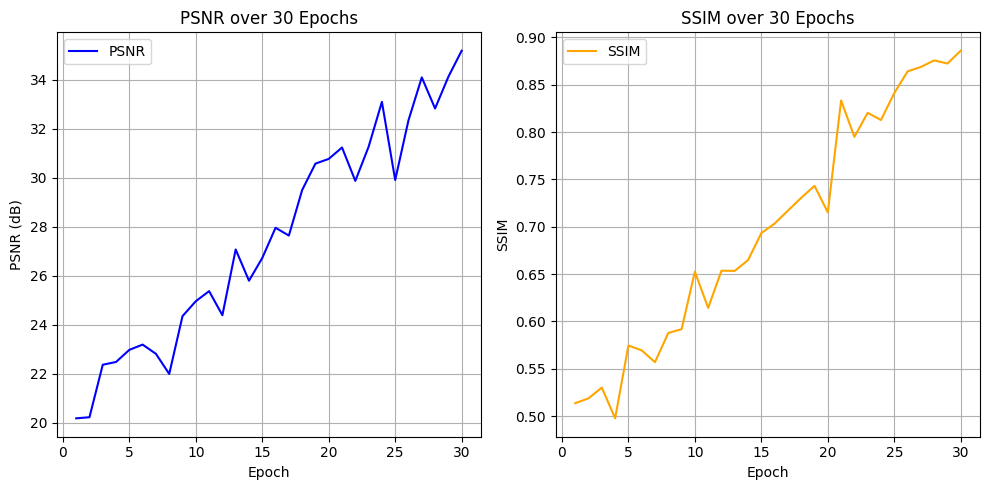

In [ ]:
_eval_plot(results)